In [538]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt   # for making figures
%matplotlib inline

In [539]:
# Read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [540]:
# number of words
len(words)

32033

In [541]:
# We build the vocabulary of characters and mappings to/from integers
# We put all the words in a single string (join), then we extracted all the characters (set), then listed and sorted them

chars = sorted(list(set(''.join(words))))

# String to integer encoder
stoi ={s:i+1 for i,s in enumerate(chars)}  # +1 translation to map '.' to 0
stoi['.'] = 0  # we mapped the special character '.' to 0

# integer to string decoder
itos ={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [542]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [543]:
# Build the dataset

# context length: how many characters do we take to predict the next one?
block_size = 3

# input X, label Y
X,Y = [], []

#for w in words :
for w in words[:5] :
    #print(w)
    # Padded context with just 0s [0,0,0] (meaning the 3 chars are '...')
    context = [0] * block_size # initiating with "..."
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]   # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [544]:
# each word is of different length
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [545]:
X,Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [546]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    """Takes a list of some words and builds the arrays X and Y
    for those words only"""
    X, Y = [], []
    for w in words:
        
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # randomly shuffling all the words
n1 = int(0.8*len(words))  # 80% training data
n2 = int(0.9*len(words))  # 10% dev/validation data, and the rest (10%) test data

Xtr, Ytr = build_dataset(words[:n1])        # building training dataset
Xdev, Ydev = build_dataset(words[n1:n2])    # building validation dataset
Xte, Yte = build_dataset(words[n2:])        # building testing dataset

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [547]:
# lookup table : 27 possible characters, and 2 embdding possibilities
C = torch.randn((27,2))

In [548]:
C

tensor([[ 0.7923, -0.3634],
        [-0.8097, -1.3054],
        [ 1.5232, -0.2611],
        [ 0.1932, -0.9110],
        [-0.2733, -0.0594],
        [ 0.7123,  0.0219],
        [ 0.3380, -0.6883],
        [ 0.5057,  0.1595],
        [-2.1275,  0.1120],
        [ 0.1188, -0.2621],
        [-0.2204,  0.4790],
        [-0.4264,  0.9837],
        [ 0.8499, -0.5822],
        [-0.3299,  1.3215],
        [-0.6332,  2.0384],
        [ 0.6333, -0.8961],
        [-0.1002,  0.6363],
        [ 0.6293,  0.9074],
        [ 1.9353, -0.2372],
        [-0.1309, -0.1955],
        [-0.0883, -0.1894],
        [ 1.7340, -1.5943],
        [-1.4117,  0.8276],
        [-0.5453,  0.0314],
        [ 0.4875,  0.2643],
        [-1.3865, -0.2300],
        [ 0.2463, -2.6053]])

In [549]:
C[X]

tensor([[[ 0.7923, -0.3634],
         [ 0.7923, -0.3634],
         [ 0.7923, -0.3634]],

        [[ 0.7923, -0.3634],
         [ 0.7923, -0.3634],
         [ 0.7123,  0.0219]],

        [[ 0.7923, -0.3634],
         [ 0.7123,  0.0219],
         [-0.3299,  1.3215]],

        [[ 0.7123,  0.0219],
         [-0.3299,  1.3215],
         [-0.3299,  1.3215]],

        [[-0.3299,  1.3215],
         [-0.3299,  1.3215],
         [-0.8097, -1.3054]],

        [[ 0.7923, -0.3634],
         [ 0.7923, -0.3634],
         [ 0.7923, -0.3634]],

        [[ 0.7923, -0.3634],
         [ 0.7923, -0.3634],
         [ 0.6333, -0.8961]],

        [[ 0.7923, -0.3634],
         [ 0.6333, -0.8961],
         [ 0.8499, -0.5822]],

        [[ 0.6333, -0.8961],
         [ 0.8499, -0.5822],
         [ 0.1188, -0.2621]],

        [[ 0.8499, -0.5822],
         [ 0.1188, -0.2621],
         [-1.4117,  0.8276]],

        [[ 0.1188, -0.2621],
         [-1.4117,  0.8276],
         [ 0.1188, -0.2621]],

        [[-1.4117,  0

In [550]:
C[X].shape

torch.Size([32, 3, 2])

In [551]:
# Embedding X
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [552]:
# Weights and bias (6 = block_size * nb of embeddings) from the 3 inputs to the next layer with 100 neurones

W1 = torch.randn((6,100))     #(nb of simultanious inputs batch_size*nb of embedding, nb of neurones in the new layer)
b1 = torch.randn(100)         # nb of bias is the same as the number of neurones in the layer

In [553]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [554]:
# view reshapes, -1 Pytorch will infer what the dimension should be in there
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [555]:
h

tensor([[-0.8908,  0.7478,  0.8858,  ...,  0.6300,  0.8478, -0.9969],
        [-0.8360,  0.8300,  0.6241,  ...,  0.4706,  0.7089, -0.9964],
        [ 0.4367,  0.9573, -0.9813,  ..., -0.7136, -0.6810, -0.9799],
        ...,
        [ 0.9956,  0.9970, -0.8655,  ..., -0.6819, -0.9262, -0.2009],
        [ 0.9840,  0.9435,  0.4088,  ...,  0.2486,  0.5444, -0.4493],
        [ 0.8726,  0.9899,  0.9797,  ...,  0.9994, -0.9957,  0.5973]])

In [556]:
h.shape

torch.Size([32, 100])

In [557]:
# Weights and bias from layer (100 neurones) to output (27 neurones that reprensents the 27 characters)

W2 = torch.randn((100, 27))   # each neurone in the outpu is fully connected to 100 weights 
b2 = torch.randn(27)          # nb of bias is the same as the number of neurones in the output

In [558]:
logits = h @ W2 + b2

In [559]:
logits.shape

torch.Size([32, 27])

In [560]:
logits

tensor([[ 7.5229e+00,  1.2297e+01, -1.6711e+01,  7.9903e+00, -2.6711e-01,
          4.1460e+00,  1.0126e+01,  1.0345e+01, -8.5159e+00, -9.0122e+00,
          1.4419e+01, -2.0245e+00,  1.0030e+01, -1.1176e+01, -5.7688e+00,
          1.1542e+01, -2.1693e+01,  7.8107e+00,  2.2111e+01,  9.2291e+00,
         -6.5213e+00,  8.4046e+00, -1.1100e+01, -4.4160e+00,  7.2250e-01,
         -5.9849e-01, -8.1562e+00],
        [ 7.8252e+00,  9.5620e+00, -1.3258e+01,  4.4855e+00,  2.9617e+00,
          3.4129e+00,  8.2416e+00,  7.0530e+00, -5.8172e+00, -5.7425e+00,
          1.4221e+01, -6.3938e-01,  1.1963e+01, -1.0550e+01, -5.2712e+00,
          1.1319e+01, -1.8910e+01,  1.0928e+01,  2.2635e+01,  7.6418e+00,
         -7.7152e+00,  6.9055e+00, -1.3638e+01, -1.3490e+00,  4.7685e-01,
         -3.8354e-01, -7.0157e+00],
        [ 8.9740e+00,  5.2553e+00,  1.3918e+01,  2.5122e+00,  1.1136e+01,
         -1.1019e+01, -4.5543e-01, -2.4520e+00,  7.9334e-04,  5.1911e+00,
          1.1246e+01, -3.8859e+00,  1.41

In [561]:
# Since counts.sum(1) 1 dimentional, keepdims=T will keep the dim of counts by copying 

# Equivalent to SoftMax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)  
prob

tensor([[4.6174e-07, 5.4658e-05, 1.3799e-17, 7.3688e-07, 1.9110e-10, 1.5771e-08,
         6.2335e-06, 7.7639e-06, 4.9986e-14, 3.0430e-14, 4.5622e-04, 3.2964e-11,
         5.6626e-06, 3.4946e-15, 7.7963e-13, 2.5698e-05, 9.4622e-20, 6.1577e-07,
         9.9944e-01, 2.5433e-06, 3.6738e-13, 1.1151e-06, 3.7730e-15, 3.0159e-12,
         5.1409e-10, 1.3720e-10, 7.1628e-14],
        [3.6973e-07, 2.0997e-06, 2.5789e-16, 1.3105e-08, 2.8555e-09, 4.4838e-09,
         5.6068e-07, 1.7082e-07, 4.3959e-13, 4.7371e-13, 2.2158e-04, 7.7939e-11,
         2.3160e-05, 3.8711e-15, 7.5892e-13, 1.2171e-05, 9.0528e-19, 8.2293e-06,
         9.9973e-01, 3.0775e-07, 6.5883e-14, 1.4738e-07, 1.7645e-16, 3.8331e-11,
         2.3797e-10, 1.0066e-10, 1.3261e-13],
        [2.2844e-04, 5.5436e-06, 3.2073e-02, 3.5682e-07, 1.9852e-03, 4.7441e-13,
         1.8350e-08, 2.4920e-09, 2.8958e-08, 5.1989e-06, 2.2167e-03, 5.9401e-10,
         3.9314e-02, 1.8246e-12, 4.9078e-10, 1.0033e-06, 4.0724e-08, 9.2109e-01,
         3.8268e-

In [562]:
prob.shape

torch.Size([32, 27])

In [563]:
# The "current probs assigned by the NN with the setting of the weights"
# to the "correct character in the sequence"

prob[torch.arange(prob.shape[0]), Y]

tensor([1.5771e-08, 3.8711e-15, 1.8246e-12, 3.1822e-11, 1.6314e-10, 2.5698e-05,
        1.2049e-04, 6.7374e-15, 2.5118e-16, 1.4608e-09, 3.3233e-11, 3.9762e-08,
        5.4658e-05, 5.4616e-14, 6.1381e-04, 2.3615e-09, 3.0430e-14, 1.6877e-05,
        5.6362e-02, 9.5909e-10, 5.2050e-04, 1.0594e-12, 1.6222e-04, 1.1584e-03,
        5.1313e-13, 2.5433e-06, 4.7088e-05, 1.3533e-14, 8.8045e-11, 1.4614e-12,
        9.1483e-09, 2.7952e-05])

In [564]:
# GOAL : Maximize the probabilities in 'prob[torch.arange(prob.shape[0]), Y]'
# Which is equivalent to minimize loss (here the negative log likelihood)

loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(19.4065)

In [565]:
# ------------ now made respectable :) ---------------

In [566]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [567]:
# context length: how many characters do we take to predict the next one?
block_size = 3
nb_of_embedding = 2  # 2 embeddings for each input-character
layer_nb_neurones = 100

g = torch.Generator().manual_seed(2147483647) # Make a generator to make it reproducible
C = torch.randn((27, nb_of_embedding), generator=g)   # lookup table : 27 possible characters, and 2 embdding possibilities
W1 = torch.randn((block_size * nb_of_embedding, layer_nb_neurones), generator=g)
b1 = torch.randn(layer_nb_neurones, generator=g)
W2 = torch.randn((layer_nb_neurones, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [568]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [569]:
for p in parameters :
    p.requires_grad = True

In [570]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre   # different learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [571]:
lri = []
lossi = []
stepi = []

In [572]:
# Gives the indeces of rows if we want to cut the X into 32
# choosing 32 values from [0, X.shape[0]]
torch.randint(0, Xtr.shape[0], (32,))

tensor([ 26943,  62535,  53941, 182178,  60416, 120977, 111539,  68409, 138234,
        131659,  26038, 172954, 170772, 141478, 164687,     68, 146038, 124046,
        148722, 165208,  36502, 105611,  18852,  18907,   6528, 168490,   8746,
         26114,   8697,  21289, 178169, 105285])

In mini-batch training, instead of using the entire dataset to update the parameters of the neural network at once, we split the dataset into smaller subsets called mini-batches. This approach offers several advantages, including faster computation, better generalization, and the ability to train on datasets that don't fit into memory.

In this example, `torch.randint(0, Xtr.shape[0], (32,))` generates 32 random indices, which are then used to select 32 random samples from the dataset X. These selected samples are then used as a mini-batch for training the neural network.

In [573]:
for i in range(1000):
    
    # minibatch construct:
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #generates random 32 nbs between 0 (inclusive) and X.shape[0] (exclusive)'
    
    # forward pass:
    emb = C[Xtr[ix]]  # if we take the first 5 words : (32,3,2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  #(32,100)
    logits = h @ W2 + b2     #(32,27)

    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims = True)  
    #loss = -prob[torch.arange(prob.shape[0]), Ytr].log().mean()

    # The code in the comment is equivalent to :
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())


    # backward pass:
    for p in parameters:
        p.grad = None  # set the grad to zero in Pytorch
    loss.backward()  # to populate the gradients

    # update:
    #lr = lrs[i]   # changing the learning rate for each iteration
    lr = 0.1 if i < 100000 else 0.01  # decaying learning rate
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

18.05297088623047
20.339874267578125
16.38929557800293
14.132797241210938
10.851057052612305
13.139492988586426
14.41169261932373
12.202083587646484
12.081863403320312
8.963445663452148
11.901579856872559
12.739858627319336
13.023053169250488
11.022418022155762
10.159730911254883
8.88373851776123
10.15989875793457
9.8653564453125
10.460197448730469
9.566261291503906
6.997876167297363
8.407488822937012
8.798745155334473
6.325514793395996
7.861620903015137
6.513376235961914
9.000697135925293
5.78754186630249
8.825408935546875
9.519615173339844
7.555211067199707
7.366701602935791
6.436266899108887
6.157889366149902
6.0017242431640625
5.985480785369873
5.955867290496826
3.786550760269165
6.031846046447754
8.929797172546387
4.635849475860596
5.792910099029541
5.1396636962890625
5.772925853729248
5.194792747497559
6.325514316558838
5.432265758514404
5.756821155548096
7.036196708679199
5.35319709777832
4.249756336212158
7.056549072265625
3.658113479614258
5.305593013763428
6.701145172119141
6

2.7151691913604736
2.6031649112701416
2.7446632385253906
2.548750877380371
2.808342218399048
2.0854320526123047
3.0330395698547363
2.7519006729125977
2.917071580886841
2.6915860176086426
2.708566665649414
2.610999584197998
2.7775630950927734
2.8122386932373047
2.3914413452148438
3.03733491897583
2.6884069442749023
2.8373911380767822
2.772876501083374
2.5053486824035645
2.9663894176483154
2.4498178958892822
2.7514140605926514
2.299659490585327
2.5124351978302
2.852739095687866
2.7607085704803467
2.512183904647827
2.682830572128296
3.18255615234375
2.5104541778564453
2.6184844970703125
2.5663816928863525
3.139735698699951
2.882134199142456
2.9482293128967285
2.974302053451538
2.6828527450561523
2.561347007751465
2.7030141353607178
3.0622477531433105
2.5308496952056885
3.1569838523864746
2.96661639213562
2.630662202835083
3.052724838256836
2.397876739501953
3.0488173961639404
2.409606456756592
2.7811973094940186
2.6308860778808594
3.2861552238464355
2.341920852661133
2.699679374694824
2.6

In [574]:
lossi

[1.2565486431121826,
 1.308348298072815,
 1.2145602703094482,
 1.1502281427383423,
 1.03547203540802,
 1.118578553199768,
 1.158715009689331,
 1.086434006690979,
 1.0821338891983032,
 0.9524750113487244,
 1.0756045579910278,
 1.105164647102356,
 1.1147128343582153,
 1.0422768592834473,
 1.0068821907043457,
 0.9485957622528076,
 1.0068893432617188,
 0.9941127896308899,
 1.0195398330688477,
 0.9807422161102295,
 0.8449662327766418,
 0.9246662855148315,
 0.9444207549095154,
 0.8010959029197693,
 0.8955121040344238,
 0.8138061761856079,
 0.9542761445045471,
 0.7624941468238831,
 0.9457348585128784,
 0.978619396686554,
 0.8782466053962708,
 0.8672730922698975,
 0.8086340427398682,
 0.7894318699836731,
 0.7782760262489319,
 0.7770990133285522,
 0.7749450206756592,
 0.5782437920570374,
 0.7804502248764038,
 0.9508416056632996,
 0.6661293506622314,
 0.7628967761993408,
 0.7109346985816956,
 0.7613959908485413,
 0.7155682444572449,
 0.8010958433151245,
 0.7349810004234314,
 0.7601827383041382,


In [575]:
logits.max(1)  # the indeces of max values approaches the values of Y

torch.return_types.max(
values=tensor([1.7772, 2.7243, 3.3035, 1.5962, 1.6270, 1.5191, 2.4856, 2.6763, 2.3459,
        3.2557, 2.2054, 2.7243, 2.7243, 2.7243, 2.6543, 2.6040, 2.0442, 1.9107,
        2.6560, 2.2037, 3.1856, 2.2198, 1.6270, 1.8130, 2.4708, 1.6285, 2.3663,
        1.3920, 3.9710, 3.3035, 2.7243, 2.7243], grad_fn=<MaxBackward0>),
indices=tensor([14,  1,  1,  0,  0,  9,  0,  0,  0,  1,  0,  1,  1,  1,  0,  5,  0,  0,
         0,  0,  1,  9,  0, 14,  0,  0,  0, 14,  1,  1,  1,  1]))

In [576]:
Ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

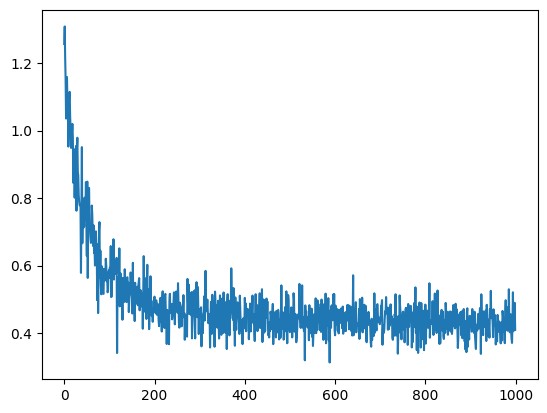

In [577]:
plt.plot(stepi, lossi);